In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods100-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ A $ □ □ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 6 s, sys: 73.1 ms, total: 6.07 s
Wall time: 6.68 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

######9# 6 None None ######0#         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 485 tga: 0     talp: 12057 tav: 22.6   num: 1


##9##### 2 None None ##0#####         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 515 tga: 5     talp: 11991 tav: 22.8   num: 1


######1# 2 None None ######0#         (empty)               q: 1.0   r: 458.3  ir: 0.0    f: 458.3  exp: 261 tga: 19    talp: 11962 tav: 52.6   num: 1


##0###0# 2 None None ##9#####         (11011101)            q: 0.379 r: 923.5  ir: 0.0    f: 350.1  exp: 688 tga: 23    talp: 12042 tav: 17.8   num: 1


######9# 2 None None ######0#         (empty)               q: 1.0   r: 438.5  ir: 0.0    f: 438.5  exp: 299 tga: 32    talp: 12041 tav: 44.0   num: 1


##1##### 6 None None ##0#####         (empty)               q: 1.0   r: 443.9  ir: 0.0    f: 443.9  exp: 261 tga: 34    talp: 12046 tav: 49.8   num: 1


##0###0# 2 None None ##1#####         (11011101)            q: 0.437 r: 923.5  ir:

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population(does_anticipate_change=True)
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 911 ms, sys: 9.01 ms, total: 920 ms
Wall time: 944 ms


### Performance

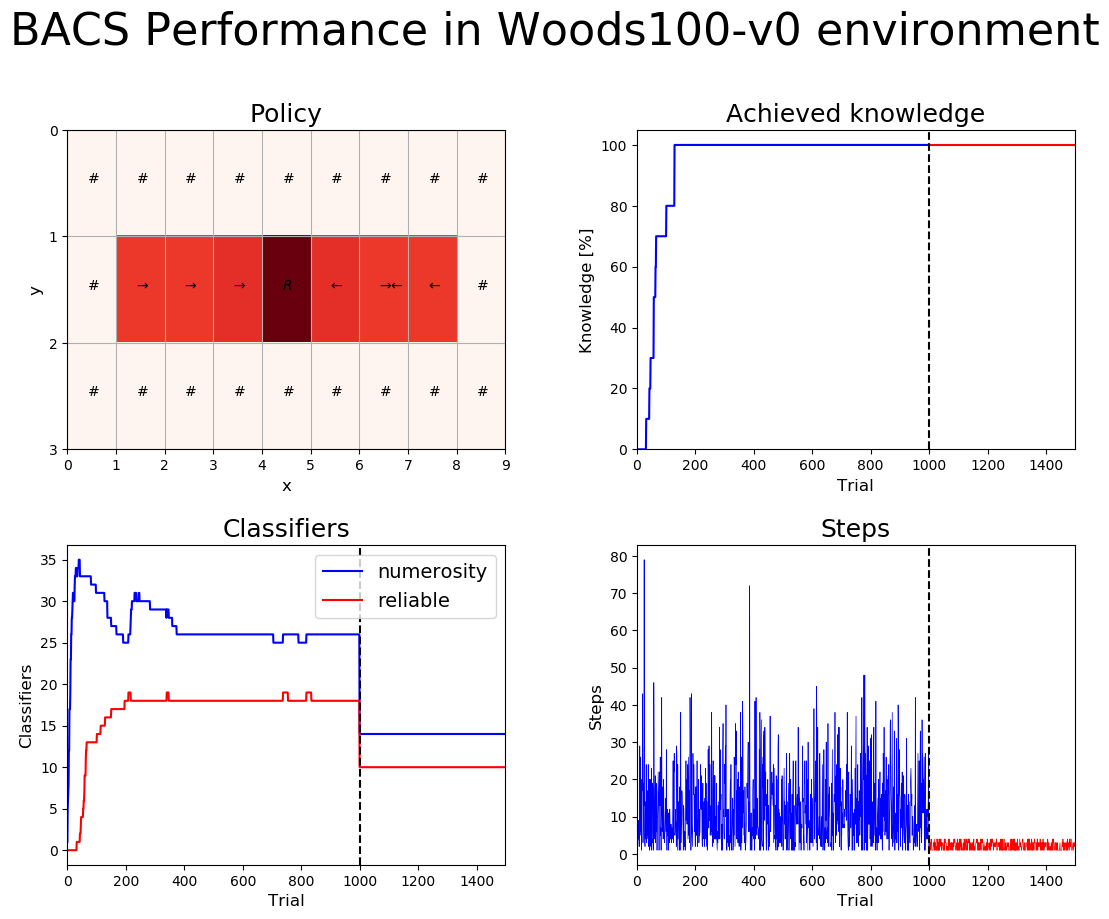

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  12.058  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  2.25  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

##9##### 2 None None ##0#####         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 515 tga: 5     talp: 11991 tav: 22.8   num: 1


######9# 6 None None ######0#         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 485 tga: 0     talp: 12057 tav: 22.6   num: 1


11011111 2 [2] [('1', '1', '0', '1', '1', '1', '0', '1')] ##9###0#         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 515 tga: 76    talp: 11991 tav: 20.8   num: 1


11111101 6 [6] [('1', '1', '0', '1', '1', '1', '0', '1')] ##0###9#         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 500 tga: 280   talp: 12051 tav: 19.4   num: 1


11911101 6 [6] [('1', '1', '0', '1', '1', '1', '0', '1')] ##0###1#         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 233 tga: 150   talp: 11885 tav: 40.6   num: 1


11011191 2 [2] [('1', '1', '0', '1', '1', '1', '0', '1')] ##1###0#         (empty)               q: 1.0   r: 902.5  ir: 0.0 